In [1]:
# !pip install cuqipy
# !pip install skimage

In [2]:
import cuqi
import numpy as np
import matplotlib.pyplot as plt
import scipy
import skimage as ski
from skimage.transform import rescale, resize, downscale_local_mean

# Load image as `x_true`

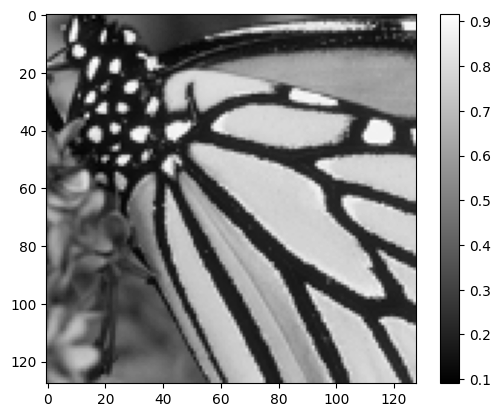

In [3]:
image = resize(ski.util.img_as_float(ski.io.imread("05.png"))[56:,56:], (128,128))
x_true = image.flatten()
dim = image.shape[0]
plt.imshow(image, cmap="gray")
plt.colorbar()

# Define mask operator (50% off) and create synthetic observation data

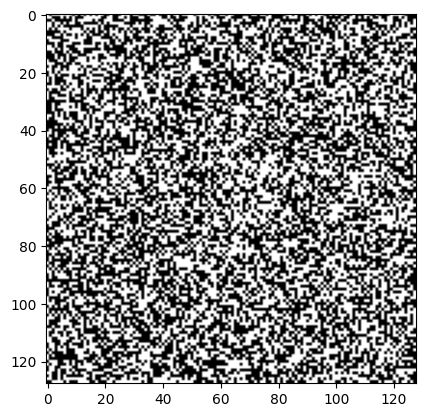

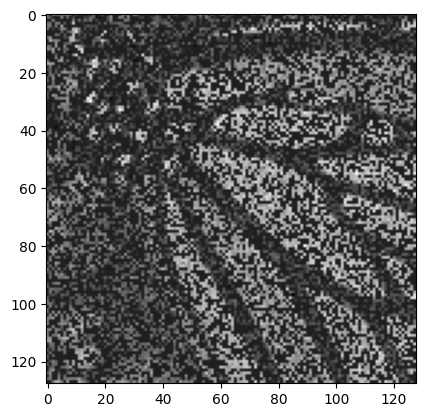

In [4]:
# define forward operator and create data
np.random.seed(1)
# manual mask
zero_density = 0.5#0.9#0.5#0.8#0.7   # we keep 50% of the pixels
mask_vector = np.random.random(size=dim**2) < zero_density
# convert mask_vector to a vector of 0s and 1s
mask_vector = mask_vector.astype(int)
mask = scipy.sparse.diags(mask_vector)
y_exact = x_true @ mask

noise_std = 0.1 # half noise
# manual noise
y_obs = y_exact + np.random.normal(0, noise_std, size=y_exact.shape)@mask

plt.imshow(mask_vector.reshape(dim, dim), cmap='gray')
plt.figure()
plt.imshow(y_obs.reshape(dim, dim), cmap='gray')

# Test effect of wavelet denoiser

## apply wavelet denoiser to `x_true` with `wavelet_levels=1`

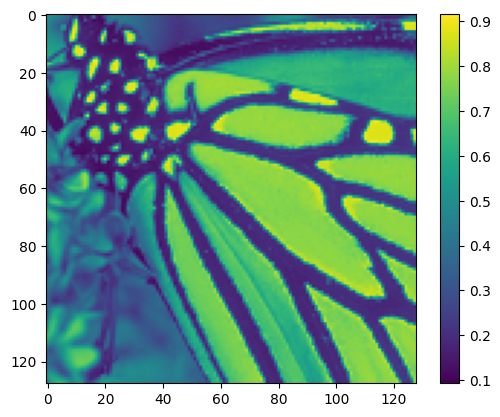

In [5]:
plt.imshow(ski.restoration.denoise_wavelet(x_true.reshape(dim, dim), sigma=0.01, wavelet="haar", wavelet_levels=1))
plt.colorbar()

## apply wavelet denoiser to `x_true` with `wavelet_levels=3`

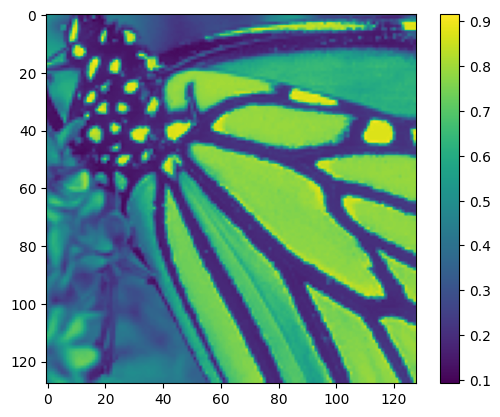

In [6]:
plt.imshow(ski.restoration.denoise_wavelet(x_true.reshape(dim, dim), sigma=0.01, wavelet="haar", wavelet_levels=3))
plt.colorbar()

## apply wavelet denoiser to `y_obs`

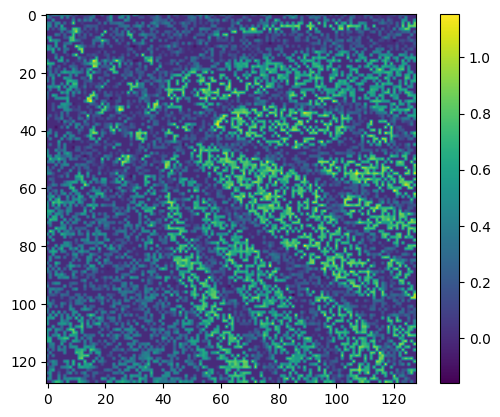

In [7]:
plt.imshow(ski.restoration.denoise_wavelet(y_obs.reshape(dim, dim), sigma=0.01, wavelet="haar"))
plt.colorbar()

# Define wavelet prior within CUQIpy

In [8]:
def nn_denoiser(x, restoration_strength=None):
    # Note 10 is used as strength of prior
    result = ski.restoration.denoise_wavelet(x.reshape(dim, dim), wavelet="haar", sigma=10*restoration_strength).reshape(dim*dim)
    return result, None

In [9]:
restorator=cuqi.implicitprior.RestorationPrior(
    nn_denoiser,
    geometry=cuqi.geometry.Image2D((dim, dim), visual_only=True),
)

In [10]:
sigma_denoiser = 0.01 # smoothing parameter for Moreau-Yoshida
myprior = cuqi.implicitprior.MoreauYoshidaPrior(restorator, sigma_denoiser)

# Define forward and likelihood in CUQIpy

In [11]:
# forward, likelihood
forward = cuqi.model.LinearModel(mask, domain_geometry=restorator.geometry, range_geometry=restorator.geometry)

prec = scipy.sparse.diags(np.ones(dim**2) / noise_std**2)  # sparse diagonal matrix
y = cuqi.distribution.Gaussian(forward@myprior, prec=prec)

In [12]:
def check_sample_fun(sample, i):
    # this function is called after each Langevin step
    if i % 1000 == 0:
        # save image
        plt.imsave(f"samples_wavelet/{i}.png", sample.reshape(dim, dim), cmap='gray')

In [13]:
# post.gradient(np.zeros(dim**2))  # just to check that the prior is defined

# Posterior sampling with ULA

In [14]:
post = cuqi.distribution.JointDistribution(myprior, y)(y=y_obs)
step_size = 1e-2
x_initial = y_obs.copy()
sampler = cuqi.experimental.mcmc.ULA(post, scale=step_size, initial_point=x_initial, callback=check_sample_fun) #, callback=check_sample_fun
sampling_steps = 60000
warmup_steps = 40000
np.random.seed(0)  # for reproducibility
sampler.warmup(warmup_steps)
sampler.sample(sampling_steps)

Sample: 100%|██████████| 60000/60000 [02:40<00:00, 372.75it/s, acc rate: 100.00%]


Sampler: ULA 
 Target: 
 	 Posterior(
    Equation:
	 p(myprior|y) ∝ L(myprior|y)p(myprior)
    Densities:
	y ~ CUQI Gaussian Likelihood function. Parameters ['myprior'].
 	myprior ~ CUQI MoreauYoshidaPrior.
 ) 
 Current state: 
	 current_point: [ 0.71153703  0.63238384  0.5685432  ... -0.08479599  0.26192503
  0.66136031] 
	 current_target_grad: [-15.33463694  -1.28307273 -10.5188317  ...  10.37443346   6.75389089
   1.7136801 ] 
	 scale: 0.01 

In [15]:
thinning = 10  # thinning factor
samples = sampler.get_samples().burnthin(warmup_steps, thinning)

In [16]:
# samples = np.load("butterfly_samples_wavelet.npy", allow_pickle=True).item()

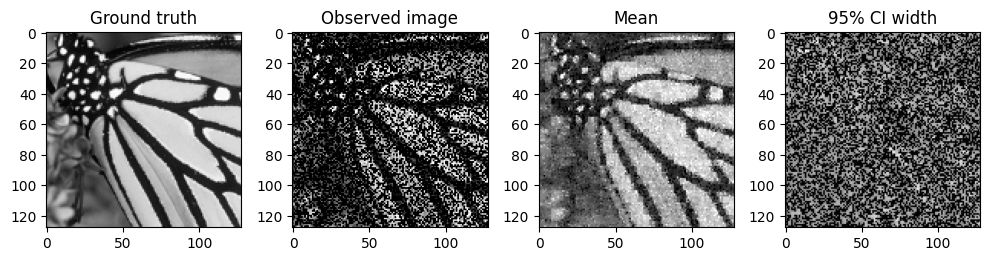

In [17]:
vmin = 0.1#-0.1
vmax = 0.9#1.1
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(10, 5))
ax1.imshow(x_true.reshape(dim, dim), cmap='gray', vmin=vmin, vmax=vmax)
ax1.set_title('Ground truth')
ax2.imshow(y_obs.reshape(dim, dim), cmap='gray', vmin=vmin, vmax=vmax)
ax2.set_title('Observed image')
ax3.imshow(samples.mean().reshape(dim, dim), cmap='gray', vmin=vmin, vmax=vmax)
ax3.set_title('Mean')
ax4.imshow(samples.ci_width().reshape(dim, dim), cmap='gray')
ax4.set_title('95% CI width')
plt.tight_layout()
plt.savefig("comparision_wavelet.pdf")

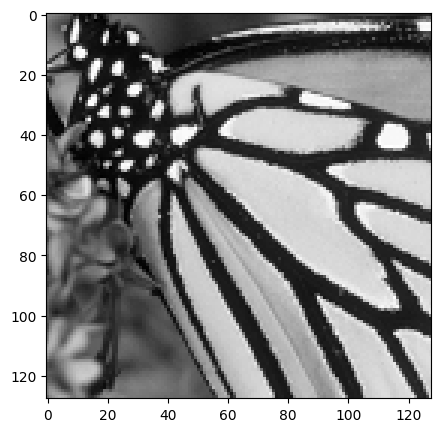

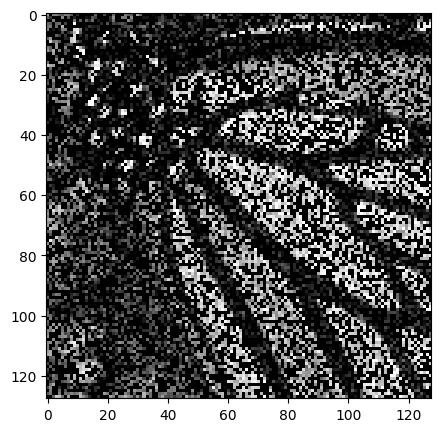

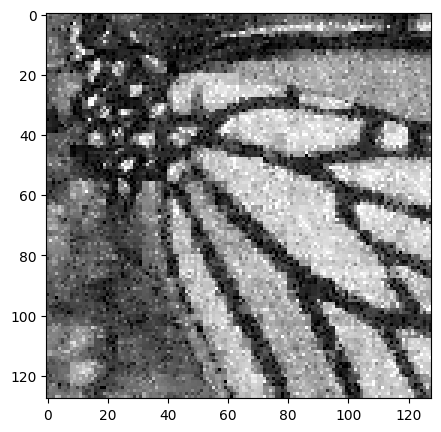

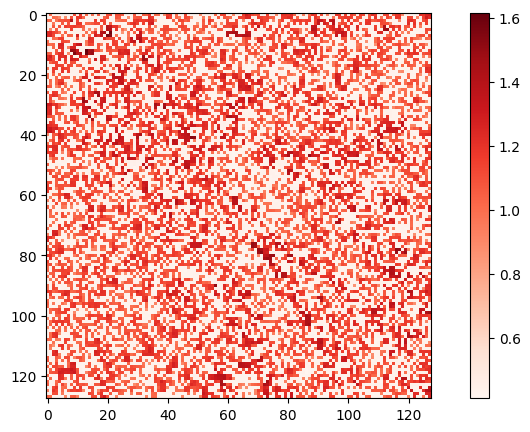

: 

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(x_true.reshape(dim, dim), cmap='gray', vmin=vmin, vmax=vmax)
plt.savefig("groundthruth_wavelet.pdf", bbox_inches='tight')
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(y_obs.reshape(dim, dim), cmap='gray', vmin=vmin, vmax=vmax)
plt.savefig("data_wavelet.pdf", bbox_inches='tight')
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(samples.mean().reshape(dim, dim), cmap='gray', vmin=vmin, vmax=vmax)
plt.savefig("mean_wavelet.pdf", bbox_inches='tight')
fig, ax = plt.subplots(figsize=(10, 5))
a = ax.imshow(samples.ci_width().reshape(dim, dim), cmap='Reds')
plt.colorbar(a)
plt.savefig("ci_width_wavelet.pdf", bbox_inches='tight')

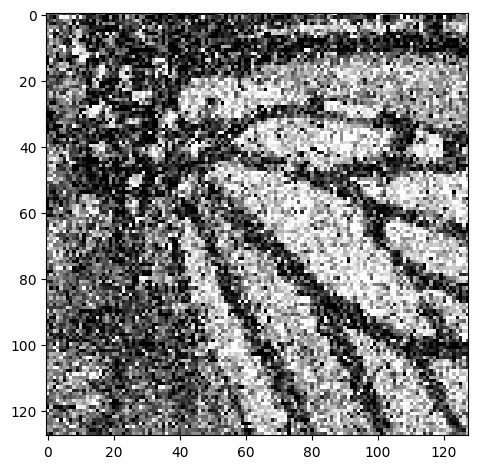

In [19]:
samples.geometry = cuqi.geometry.Image2D((dim, dim))
samples.plot(-1, vmin=vmin, vmax=vmax)
plt.tight_layout()
plt.savefig("one_sample_wavelet.pdf")

Selecting 5 randomly chosen variables


array([[<Axes: title={'center': 'v1224'}>,
        <Axes: title={'center': 'v1224'}>],
       [<Axes: title={'center': 'v3090'}>,
        <Axes: title={'center': 'v3090'}>],
       [<Axes: title={'center': 'v5060'}>,
        <Axes: title={'center': 'v5060'}>],
       [<Axes: title={'center': 'v13432'}>,
        <Axes: title={'center': 'v13432'}>],
       [<Axes: title={'center': 'v14919'}>,
        <Axes: title={'center': 'v14919'}>]], dtype=object)

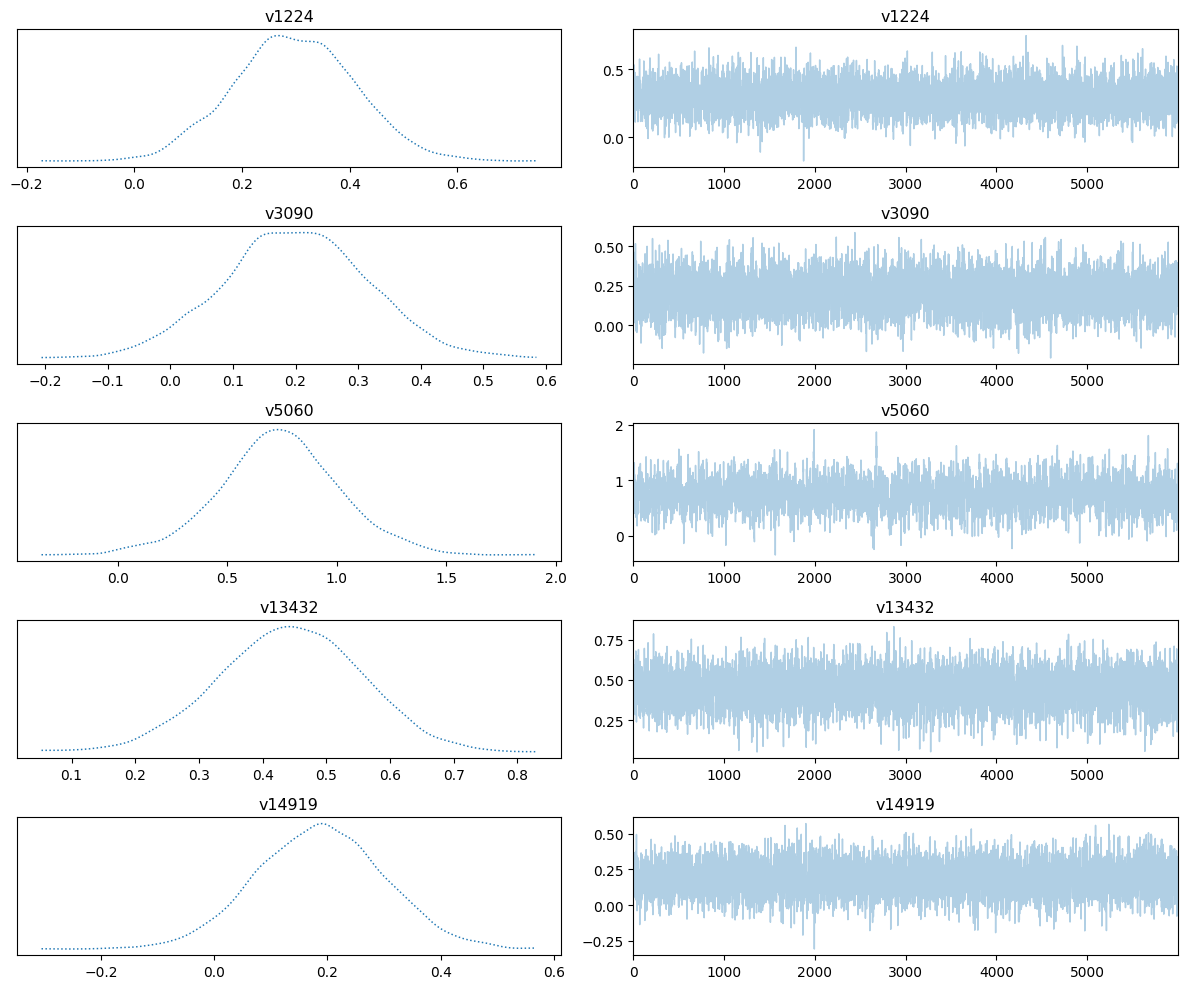

In [21]:
samples.plot_trace()

In [22]:
# np.save("butterfly_samples_wavelet.npy", samples)

# check variance and mask

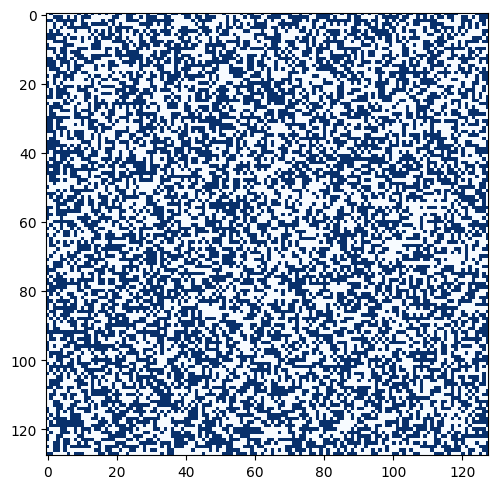

In [24]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(mask_vector.reshape(dim, dim), cmap='Blues_r')
plt.tight_layout()
plt.savefig("mask.pdf", bbox_inches='tight')